In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import torch
from transformers import AutoFeatureExtractor, WhisperModel, WhisperProcessor
from transformers import pipeline
import torchaudio
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.neural_network import MLPClassifier

from torchinfo import summary
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [15]:
processor = WhisperProcessor.from_pretrained("openai/whisper-base")
model = WhisperModel.from_pretrained("openai/whisper-base")

def process_file(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    waveform = torch.mean(waveform, dim=0, keepdim=False)
    #waveform = torchaudio.transforms.Vad(sample_rate=16000)(waveform).squeeze(0)
    
    inputs = processor(waveform, sampling_rate=16000, return_tensors="pt")
   
    
    with torch.no_grad():
        encoder_outputs = model.encoder(inputs.input_features).last_hidden_state
    #print(encoder_outputs.shape)
    return encoder_outputs

process_file("data/voc-als-data-wav/CT001_phonationE.wav")

tensor([[[-1.4901,  0.4910, -0.6511,  ..., -0.6344,  1.0671,  0.7626],
         [-0.2755,  0.2858,  0.6054,  ..., -0.2588,  0.7666,  0.3234],
         [-0.2191,  1.0572,  0.2114,  ..., -0.7902,  0.6914,  0.3232],
         ...,
         [-0.4014, -1.0865,  0.3372,  ...,  0.5190, -0.4958,  0.6408],
         [-0.7207, -0.9906,  0.2412,  ...,  0.4102, -0.0178,  0.4921],
         [-0.7329, -0.5356,  0.9796,  ...,  0.1833, -0.8070, -1.0586]]])

In [7]:
all_df = pd.read_csv("edward_uppercase_acoustic_features.csv", sep=',',  decimal=',')
print(all_df['Dataset'].unique())
print(all_df['label'].unique())
print(all_df['Phoneme'].unique())
#all_df = all_df.sample(frac=1).reset_index(drop=True) # shuffle

['VOC-ALS' 'PD_dataset_2' 'MSA' 'PSP' 'PD_dataset_1' 'PD_dataset_3'
 'MINSK' 'Italian']
['ALS' 'HC' 'PD' 'MSA' 'PSP']
['A' 'E' 'I' 'O' 'U']


In [8]:
files = all_df['voiced_file_path']
embeddings = []
for file in files:
    embeddings.append(process_file(file))
embeddings_t = torch.cat(embeddings)

In [75]:
all_df['embedding_idx'] = range(len(all_df))

In [98]:
def train_df(df,model):
    y = df['label']
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    subjects = df['subjectID'].unique()
    train_subjects, test_subjects = train_test_split(subjects, test_size=0.3, random_state=0)
    X = embeddings_t.mean(dim=1).detach().numpy()
    X_train, X_test, y_train, y_test = X[df['embedding_idx'][df['subjectID'].isin(train_subjects)]], X[df['embedding_idx'][df['subjectID'].isin(test_subjects)]], y[df['subjectID'].isin(train_subjects)], y[df['subjectID'].isin(test_subjects)]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "encoder": encoder
    }
train_df(all_df, LogisticRegression(max_iter=10000, class_weight='balanced'))[0]

              precision    recall  f1-score   support

         ALS       0.68      0.67      0.68       187
          HC       0.63      0.62      0.63       179
         MSA       0.24      0.53      0.33        17
          PD       0.74      0.68      0.71       150
         PSP       0.50      0.50      0.50        34

    accuracy                           0.64       567
   macro avg       0.56      0.60      0.57       567
weighted avg       0.66      0.64      0.65       567


0.6437389770723104

In [77]:
df = all_df[(all_df['Phoneme'] == 'A') & (all_df['label'].isin(['HC', 'ALS']))]

In [78]:
import seaborn as sns

def test_model(model):
    accuracies = pd.DataFrame(columns=all_df['Phoneme'].unique(), index=all_df['label'].unique(), dtype='float')
    f1_scores = pd.DataFrame(columns=all_df['Phoneme'].unique(), index=all_df['label'].unique(), dtype='float')
    for phoneme in all_df['Phoneme'].unique():
        for label in all_df['label'].unique():
            if label == 'HC':
                continue
            print(f'Phoneme: {phoneme}, label: {label}')
            df = all_df[(all_df['Phoneme'] == phoneme) & (all_df['label'].isin(['HC', label]))]
            if df['label'].nunique() < 2:
                continue
            acc, f1, _ = train_df(df, model)
            accuracies.loc[label, phoneme] = acc
            f1_scores.loc[label, phoneme] = f1
    return accuracies, f1_scores
            
model = LogisticRegression(max_iter=10000, class_weight='balanced')
acc, f1s = test_model(model)
acc.drop(labels=['HC'], inplace=True)
f1s.drop(labels=['HC'], inplace=True)
acc

Phoneme: A, label: ALS
              precision    recall  f1-score   support

         ALS       0.68      0.65      0.67        46
          HC       0.80      0.82      0.81        79

    accuracy                           0.76       125
   macro avg       0.74      0.74      0.74       125
weighted avg       0.76      0.76      0.76       125

Phoneme: A, label: PD
              precision    recall  f1-score   support

          HC       0.69      0.72      0.71        80
          PD       0.64      0.60      0.62        65

    accuracy                           0.67       145
   macro avg       0.66      0.66      0.66       145
weighted avg       0.67      0.67      0.67       145

Phoneme: A, label: MSA
              precision    recall  f1-score   support

          HC       0.99      0.90      0.94        82
         MSA       0.65      0.94      0.77        16

    accuracy                           0.91        98
   macro avg       0.82      0.92      0.86        98
weight

,A,E,I,O,U
ALS,0.760000,0.733333,0.784946,0.800000,0.583333
PD,0.668966,0.822222,0.731707,0.911111,0.911111
MSA,0.908163,NaN,0.876923,NaN,NaN
PSP,0.895833,NaN,0.857143,NaN,NaN


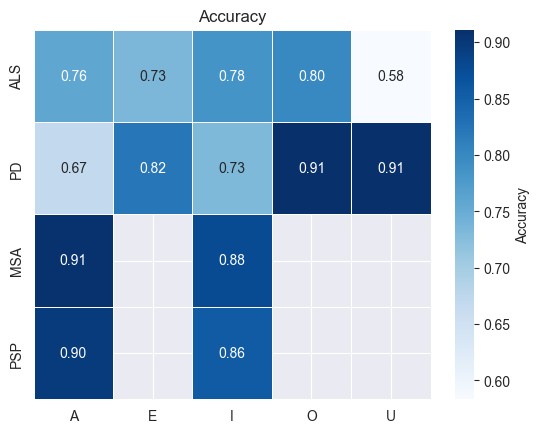

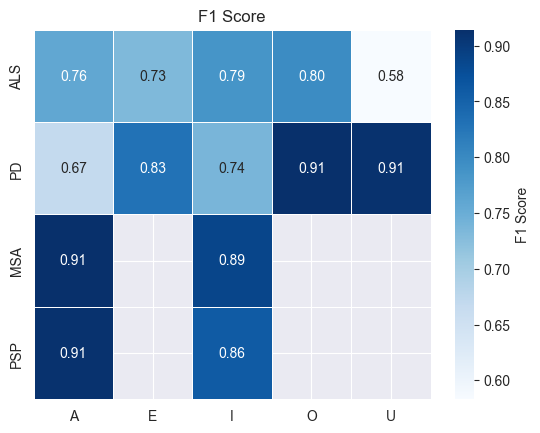

In [79]:
def plot_heatmap(data, title):
    sns.heatmap(
        data,
        annot=True,
        cmap='Blues',
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={'label': title},
        annot_kws={"size": 10}
    )
    plt.title(title)
    plt.show()
    
plot_heatmap(acc, 'Accuracy')
plot_heatmap(f1s, 'F1 Score')

In [80]:
model = MLPClassifier(max_iter=10000, hidden_layer_sizes=(256, 128, 64), activation='relu', alpha=0.01)
acc, f1s = test_model(model)
acc.drop(labels=['HC'], inplace=True)
f1s.drop(labels=['HC'], inplace=True)
acc

Phoneme: A, label: ALS
              precision    recall  f1-score   support

         ALS       0.60      0.72      0.65        46
          HC       0.81      0.72      0.77        79

    accuracy                           0.72       125
   macro avg       0.71      0.72      0.71       125
weighted avg       0.74      0.72      0.72       125

Phoneme: A, label: PD
              precision    recall  f1-score   support

          HC       0.77      0.71      0.74        80
          PD       0.68      0.74      0.71        65

    accuracy                           0.72       145
   macro avg       0.72      0.73      0.72       145
weighted avg       0.73      0.72      0.72       145

Phoneme: A, label: MSA
              precision    recall  f1-score   support

          HC       0.97      0.95      0.96        82
         MSA       0.78      0.88      0.82        16

    accuracy                           0.94        98
   macro avg       0.88      0.91      0.89        98
weight

,A,E,I,O,U
ALS,0.720000,0.716667,0.784946,0.750000,0.550000
PD,0.724138,0.844444,0.768293,0.933333,0.911111
MSA,0.938776,NaN,0.923077,NaN,NaN
PSP,0.875000,NaN,0.793651,NaN,NaN


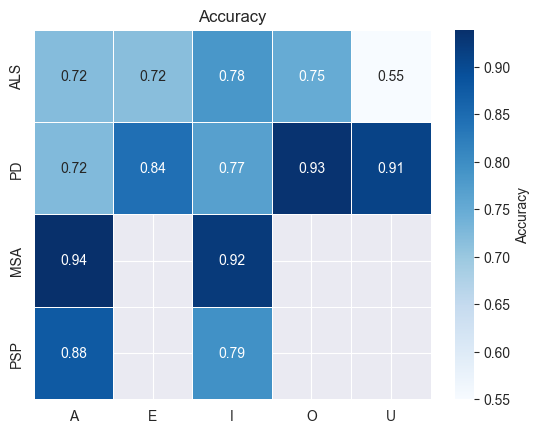

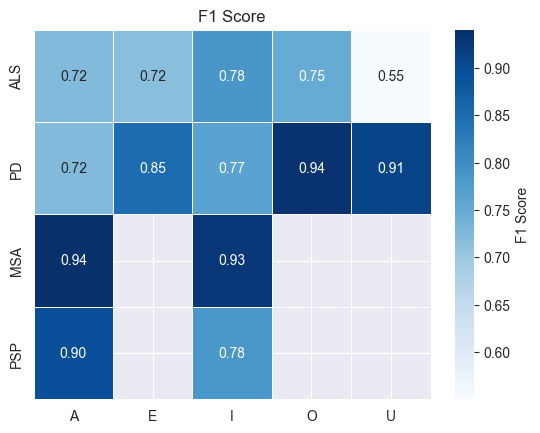

In [81]:
plot_heatmap(acc, 'Accuracy')
plot_heatmap(f1s, 'F1 Score')

In [101]:
als_df = all_df[(all_df['Dataset'] == 'VOC-ALS') & (all_df['Phoneme'] == 'I')]
model = LogisticRegression(max_iter=10000, class_weight='balanced')
acc, f1, info = train_df(als_df, model)
test_df = all_df[(all_df['Dataset'] == 'MINSK') & (all_df['Phoneme'] == 'I')]
test_y = info['encoder'].transform(test_df['label'])
X_test = embeddings_t.mean(dim=1).detach().numpy()[test_df['embedding_idx']]
y_pred = model.predict(X_test)
print(classification_report(test_y, y_pred, target_names=info['encoder'].classes_))

              precision    recall  f1-score   support

         ALS       0.81      0.81      0.81        31
          HC       0.60      0.60      0.60        15

    accuracy                           0.74        46
   macro avg       0.70      0.70      0.70        46
weighted avg       0.74      0.74      0.74        46
              precision    recall  f1-score   support

         ALS       0.63      0.77      0.70        31
          HC       0.73      0.58      0.64        33

    accuracy                           0.67        64
   macro avg       0.68      0.67      0.67        64
weighted avg       0.68      0.67      0.67        64


In [88]:
from sklearn.metrics import mean_squared_error, r2_score

def train_df_regress(df,model):
    df = df[df['Severity'].notna()]
    y = df['Severity']
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    subjects = df['subjectID'].unique()
    if df.size < 10:
        return np.nan, np.nan, None
    train_subjects, test_subjects = train_test_split(subjects, test_size=0.3, random_state=0)
    X = embeddings_t.mean(dim=1).detach().numpy()
    X_train, X_test, y_train, y_test = X[df['embedding_idx'][df['subjectID'].isin(train_subjects)]], X[df['embedding_idx'][df['subjectID'].isin(test_subjects)]], y[df['subjectID'].isin(train_subjects)], y[df['subjectID'].isin(test_subjects)]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred) / len(y_test), r2_score(y_test, y_pred) / len(y_test), {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }
train_df_regress(all_df, LinearRegression())[0]

0.17749136035891497

In [89]:

def test_model_regress(model):
    mses = pd.DataFrame(columns=all_df['Phoneme'].unique(), index=all_df['label'].unique(), dtype='float')
    r2s = pd.DataFrame(columns=all_df['Phoneme'].unique(), index=all_df['label'].unique(), dtype='float')
    for phoneme in all_df['Phoneme'].unique():
        for label in all_df['label'].unique():
            if label == 'HC':
                continue
            print(f'Phoneme: {phoneme}, label: {label}')
            df = all_df[(all_df['Phoneme'] == phoneme) & (all_df['label'].isin(['HC', label]))]
            if df['label'].nunique() < 2:
                continue
            ms, r2, _ = train_df_regress(df, model)
            mses.loc[label, phoneme] = ms
            r2s.loc[label, phoneme] = r2
    return mses, r2s
            
model = LinearRegression()
mses, r2s = test_model_regress(model)
mses.drop(labels=['HC'], inplace=True)
r2s.drop(labels=['HC'], inplace=True)
mses

Phoneme: A, label: ALS
Phoneme: A, label: PD
Phoneme: A, label: MSA
Phoneme: A, label: PSP
Phoneme: E, label: ALS
Phoneme: E, label: PD
Phoneme: E, label: MSA
Phoneme: E, label: PSP
Phoneme: I, label: ALS
Phoneme: I, label: PD
Phoneme: I, label: MSA
Phoneme: I, label: PSP
Phoneme: O, label: ALS
Phoneme: O, label: PD
Phoneme: O, label: MSA
Phoneme: O, label: PSP
Phoneme: U, label: ALS
Phoneme: U, label: PD
Phoneme: U, label: MSA
Phoneme: U, label: PSP


,A,E,I,O,U
ALS,0.389856,0.589784,0.297632,0.436503,0.237247
PD,NaN,NaN,NaN,NaN,NaN
MSA,NaN,NaN,NaN,NaN,NaN
PSP,NaN,NaN,NaN,NaN,NaN
